# Playing with wawy things

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Field of random particles

In [135]:
D = (6, 6)
N = 1000
x, y = np.random.random(size=(2, N))
x *= D[0]
y *= D[1]

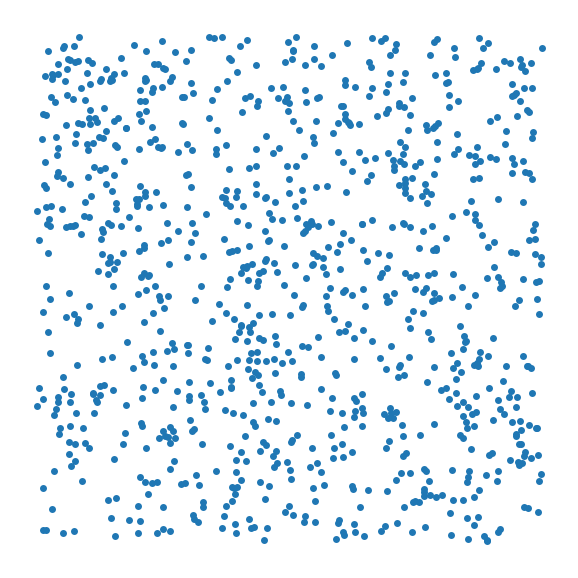

In [136]:
fig, ax = plt.subplots(figsize=D, dpi=120, facecolor='white')
ax.set_aspect('equal')
ax.axis('off')

ax.scatter(x, y, marker='o', s=10)

plt.show()

## Generating 2D waves

### Grid generation to evaluate wave equation on

In [416]:
res = 100
xi = np.linspace(0, D[0], D[0]*res)
yi = np.linspace(0, D[1], D[1]*res)
X, Y = np.meshgrid(xi, yi)

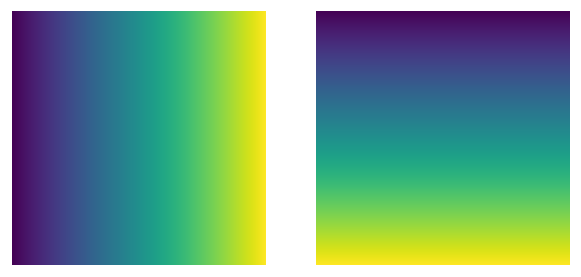

In [417]:
nr, nc = 1, 2
fig, axes = plt.subplots(nr, nc, figsize=(nr*D[0], nc*D[1]), dpi=120,
                         facecolor='white')
axes = axes.flatten()

for ax, C in zip(axes, [X, Y]):
    ax.axis('off')
    ax.imshow(C)

plt.show()

### Wave equation

In [418]:
# Wave parameters
A = 1.0
c = 1.0

In [419]:
def wave(t, X, Y, x0, y0, A, c):
    r = np.sqrt((X-x0)**2 + (Y-y0)**2)
    wave = A * np.heaviside(t - r/c, 1) * np.cos(2*np.pi*(t - r/c))
    noise = np.random.normal(0, A/8, X.shape)
    return wave+noise

In [444]:
a = 6
l = 3
xy1 = (a/2, a/2 + l)
xy2 = (a/2 - l*np.sqrt(3)/2, a/2 - l/2)
xy3 = (a/2 + l*np.sqrt(3)/2, a/2 - l/2)

In [447]:
def polygon_vertices(a: float, l: float, n: int):
    """
    Calculate the vertices of a regular polygon inscribed in a square.

    Parameters:
    a (float): The side length of the square.
    l (float): The distance from the center of the square to the top vertex of the polygon.
    n (int): The number of sides of the polygon.

    Returns:
    list: The coordinates of the vertices.
    """
    if n < 3:
        raise ValueError("The number of sides `n` must be at least 3.")
    center_x, center_y = a / 2, a / 2
    vertices = []
    for i in range(n):
        angle = 2 * np.pi * i / n
        x = center_x + l * np.cos(angle)
        y = center_y + l * np.sin(angle)
        vertices.append((x, y))
    return vertices

In [467]:
a, l, n = 6, 3, 5
vertices = polygon_vertices(a=a, l=l, n=n)

In [468]:
t = 5
Z = np.zeros_like(X)
for x, y in vertices:
    Z += wave(t=t, X=X, Y=Y, x0=x, y0=y, A=1.0, c=1.0)

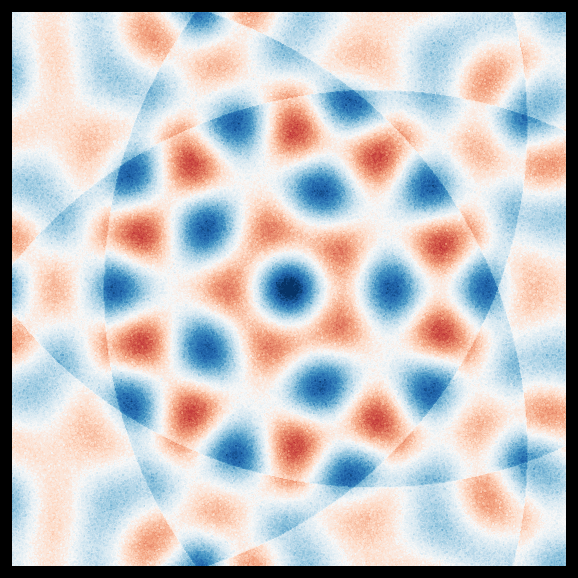

In [469]:
fig, ax = plt.subplots(figsize=D, dpi=120, facecolor='black')
ax.set_aspect('equal')
ax.axis('off')

ax.contourf(X, Y, Z, levels=np.linspace(-n, n, 50), cmap='RdBu')

plt.show()

In [471]:
def animate(i):
    t = i/40
    Z = np.zeros_like(X)
    for x, y in vertices:
        Z += wave(t=t, X=X, Y=Y, x0=x, y0=y, A=1.0, c=1.0)
    ax.clear()
    ax.contourf(X, Y, Z, levels=np.linspace(-n, n, 50), cmap='RdBu')

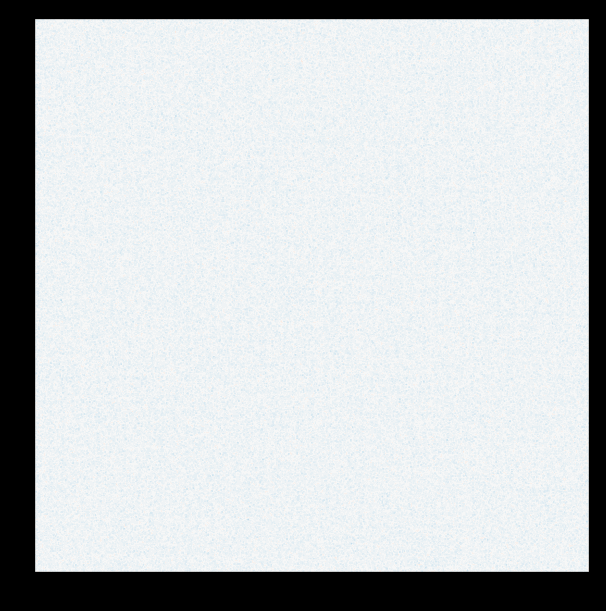

In [472]:
fig, ax = plt.subplots(figsize=D, dpi=120, facecolor='black')
ax.set_aspect('equal')
ax.axis('off')
ani = animation.FuncAnimation(fig, animate, frames=280)

# Save animation
ani.save('wave_animation.mp4', fps=60, writer='ffmpeg')
# or save as gif
# ani.save('wave_animation.gif', writer='imagemagick')